In [3]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb"
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb"
%run "get_backbround_average_.ipynb"
%run "frame_vs_temperature.ipynb"

# Input Files

### input needed: name of the folder containing different velocity's picture

In [4]:
folder = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_1"
folder_2 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_2"
folder_3 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_3"
folder_4 = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/11092022_4"

In [5]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

In [6]:
all_files_2, fivemm_files_2, velocity_path_list_2, velocity_list_2, used_frame_num_2 = get_needed_files(folder_2)
back_intensity_list_2 = get_background_average(fivemm_files_2)
power_list_2 = get_powers(all_files_2)

In [7]:
all_files_3, fivemm_files_3, velocity_path_list_3, velocity_list_3, used_frame_num_3 = get_needed_files(folder_3)
back_intensity_list_3 = get_background_average(fivemm_files_3)
power_list_3 = get_powers(all_files_3)

In [8]:
all_files_4, fivemm_files_4, velocity_path_list_4, velocity_list_4, used_frame_num_4 = get_needed_files(folder_4)
back_intensity_list_4 = get_background_average(fivemm_files_4)
power_list_4 = get_powers(all_files_4)

# Get kappa (silicon melt)

### input need: si melting power at specific velocity

### Data set 1

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.0001929214140380236

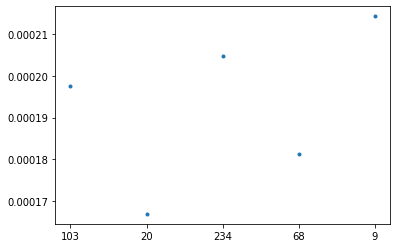

In [533]:
Si_list = ['103', '20', '234', '68', '9']
Si_melting_W = {
    '103': 51,
    '20': 45,
    '234': 57,
    '68': 49,
    '9': 43
}

Dict_Si = dict((k, fivemm_files[k][10:]) for k in Si_list)
back_intensity_list_Si = []
for key in fivemm_files:
    if key in Si_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_Si.append(back_intensity_list[index])

#Dict_dRoverR = dict.fromkeys(list(Dict_gold.keys()),[])
dRoverR = []
for i, v in enumerate(list(Dict_Si.keys())):
    con = []
    for file in Dict_Si[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR.append(con)

power_Si = []
for i, (key, value) in enumerate(fivemm_files.items()):
    if key in Si_list:
        power_Si.append(power_list[i][1:])

for i, v in enumerate(list(Dict_Si.keys())):
    plt.plot(power_Si[i][:-1], dRoverR[i][:-1], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure/{}mm.png".format(v), format="PNG")
    plt.close()

kappa_Si = []
for i, v in enumerate(list(Dict_Si.keys())):
    power = [float(j) for j in power_Si[i]][:-1]
    y = dRoverR[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.0000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    Si_m = 1410
    dT = Si_m - 21
    kappa = f / dT
    kappa_Si.append(kappa)
    
Dict_kappa_S_1 = dict(zip(list(Dict_Si.keys()),kappa_Si))

plt.plot(list(Dict_Si.keys()), kappa_Si, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si.png", format="PNG")

avg_kappa_Si = sum(kappa_Si) / len(kappa_Si)
avg_kappa_Si

### Data set 2

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.00018595091592120666

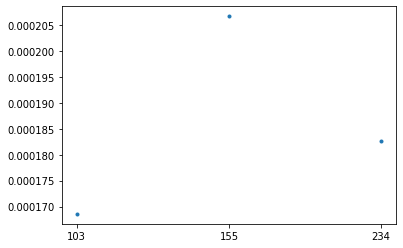

In [535]:
Si_list = ['103', '155', '234']
Si_melting_W = {
    '103': 51,
    '155': 55,
    '234': 57
}

Dict_Si = dict((k, fivemm_files_2[k][10:]) for k in Si_list)
back_intensity_list_Si = []
for key in fivemm_files_2:
    if key in Si_list:
        index = list(fivemm_files_2).index(key)
        back_intensity_list_Si.append(back_intensity_list_2[index])

#Dict_dRoverR = dict.fromkeys(list(Dict_gold.keys()),[])
dRoverR = []
for i, v in enumerate(list(Dict_Si.keys())):
    con = []
    for file in Dict_Si[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR.append(con)

power_Si = []
for i, (key, value) in enumerate(fivemm_files_2.items()):
    if key in Si_list:
        power_Si.append(power_list_2[i][1:])

for i, v in enumerate(list(Dict_Si.keys())):
    plt.plot(power_Si[i][:-1], dRoverR[i][:-1], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_2/{}mm.png".format(v), format="PNG")
    plt.close()

kappa_Si = []
for i, v in enumerate(list(Dict_Si.keys())):
    power = [float(j) for j in power_Si[i]][:-1]
    y = dRoverR[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.0000002, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure_2/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    Si_m = 1410
    dT = Si_m - 21
    kappa = f / dT
    kappa_Si.append(kappa)
    
Dict_kappa_Si_2 = dict(zip(list(Dict_Si.keys()),kappa_Si))

plt.plot(list(Dict_Si.keys()), kappa_Si, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si_2.png", format="PNG")

avg_kappa_Si = sum(kappa_Si) / len(kappa_Si)
avg_kappa_Si

### Data set 3

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.00018925322919406717

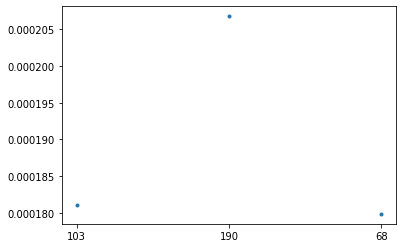

In [531]:
Si_list = ['103', '190', '68']
Si_melting_W = {
    '103': 51,
    '190': 55,
    '68': 49
}

Dict_Si = dict((k, fivemm_files_3[k][10:]) for k in Si_list)
back_intensity_list_Si = []
for key in fivemm_files_3:
    if key in Si_list:
        index = list(fivemm_files_3).index(key)
        back_intensity_list_Si.append(back_intensity_list_3[index])

#Dict_dRoverR = dict.fromkeys(list(Dict_gold.keys()),[])
dRoverR = []
for i, v in enumerate(list(Dict_Si.keys())):
    con = []
    for file in Dict_Si[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR.append(con)

power_Si = []
for i, (key, value) in enumerate(fivemm_files_3.items()):
    if key in Si_list:
        power_Si.append(power_list_3[i][1:])

for i, v in enumerate(list(Dict_Si.keys())):
    plt.plot(power_Si[i][:-1], dRoverR[i][:-1], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_3/{}mm.png".format(v), format="PNG")
    plt.close()

kappa_Si = []
for i, v in enumerate(list(Dict_Si.keys())):
    power = [float(j) for j in power_Si[i]][:-1]
    y = dRoverR[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure_3/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    Si_m = 1410
    dT = Si_m - 21
    kappa = f / dT
    kappa_Si.append(kappa)
    
Dict_kappa_Si_3 = dict(zip(list(Dict_Si.keys()),kappa_Si))

plt.plot(list(Dict_Si.keys()), kappa_Si, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si_3.png", format="PNG")

avg_kappa_Si = sum(kappa_Si) / len(kappa_Si)
avg_kappa_Si

### Data set 4

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.0001828065343291713

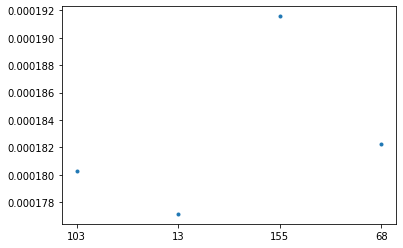

In [532]:
Si_list = ['103', '13', '155', '68']
Si_melting_W = {
    '103': 51,
    '13': 43,
    '155': 53,
    '68': 49
}

Dict_Si = dict((k, fivemm_files_4[k][10:]) for k in Si_list)
back_intensity_list_Si = []
for key in fivemm_files_4:
    if key in Si_list:
        index = list(fivemm_files_4).index(key)
        back_intensity_list_Si.append(back_intensity_list_4[index])

#Dict_dRoverR = dict.fromkeys(list(Dict_gold.keys()),[])
dRoverR = []
for i, v in enumerate(list(Dict_Si.keys())):
    con = []
    for file in Dict_Si[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR.append(con)

power_Si = []
for i, (key, value) in enumerate(fivemm_files_4.items()):
    if key in Si_list:
        power_Si.append(power_list_4[i][1:])

for i, v in enumerate(list(Dict_Si.keys())):
    plt.plot(power_Si[i][:-1], dRoverR[i][:-1], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_4/{}mm.png".format(v), format="PNG")
    plt.close()

kappa_Si = []
for i, v in enumerate(list(Dict_Si.keys())):
    power = [float(j) for j in power_Si[i]][:-1]
    y = dRoverR[i][:-1]
    popt, pcov = curve_fit(expo, power, y, p0 = [1, 0.0000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power, y, '.')
    y_pred = [expo(j, *popt) for j in power]
    plt.plot(power, y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure_4/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    Si_m = 1410
    dT = Si_m - 21
    kappa = f / dT
    kappa_Si.append(kappa)
    
Dict_kappa_Si_4 = dict(zip(list(Dict_Si.keys()),kappa_Si))

plt.plot(list(Dict_Si.keys()), kappa_Si, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si_4.png", format="PNG")

avg_kappa_Si = sum(kappa_Si) / len(kappa_Si)
avg_kappa_Si

### use average dR/R

In [10]:
Si_list = ['103', '13', '155', '190', '20', '68', '9']
Si_melting_W = {
    '103': 51,
    '13': 43,
    '155': 53,
    '190': 55,
    '20': 45,
    '68': 49,
    '9': 41
}

Dict_Si_1 = dict((k, fivemm_files[k][10:]) for k in Si_list)
Dict_Si_2 = dict((k, fivemm_files_2[k][10:]) for k in Si_list)
Dict_Si_3 = dict((k, fivemm_files_3[k][10:]) for k in Si_list)
#Dict_Si_4 = dict((k, fivemm_files_4[k][10:]) for k in Si_list)

back_intensity_list_Si_1 = []
back_intensity_list_Si_2 = []
back_intensity_list_Si_3 = []
#back_intensity_list_Si_4 = []

for key in fivemm_files:
    if key in Si_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_Si_1.append(back_intensity_list[index])
for key in fivemm_files_2:
    if key in Si_list:
        index = list(fivemm_files_2).index(key)
        back_intensity_list_Si_2.append(back_intensity_list_2[index])
for key in fivemm_files_3:
    if key in Si_list:
        index = list(fivemm_files_3).index(key)
        back_intensity_list_Si_3.append(back_intensity_list_3[index])
#for key in fivemm_files_4:
#    if key in Si_list:
#        index = list(fivemm_files_4).index(key)
#        back_intensity_list_Si_4.append(back_intensity_list_4[index])

dRoverR_1 = []
dRoverR_2 = []
dRoverR_3 = []
#dRoverR_4 = []

for i, v in enumerate(list(Dict_Si_1.keys())):
    con = []
    for file in Dict_Si_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

for i, v in enumerate(list(Dict_Si_2.keys())):
    con = []
    for file in Dict_Si_2[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_2[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_2.append(con)

for i, v in enumerate(list(Dict_Si_3.keys())):
    con = []
    for file in Dict_Si_3[v]:
        val = get_peak_dRoverR(file, back_intensity_list_Si_3[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_3.append(con)

#for i, v in enumerate(list(Dict_gold_4.keys())):
#    con = []
#    for file in Dict_gold_4[v]:
#        val = get_peak_dRoverR(file, back_intensity_list_gold_4[i], two_lorentz, two_lorentz)
#        con.append(val)
#    dRoverR_4.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [11]:
for i in range(0,len(dRoverR_1),1):
    dRoverR_1[i] = dRoverR_1[i][:-1]

for i in range(0,len(dRoverR_2),1):
    dRoverR_2[i] = dRoverR_2[i][:-1]

for i in range(0,len(dRoverR_3),1):
    dRoverR_3[i] = dRoverR_3[i][:-1]

#for i in range(0,len(dRoverR_4),1):
#    dRoverR_4[i] = dRoverR_4[i][:-1]

In [12]:
for i in range(0, len(Si_list), 1):
    while not (len(dRoverR_1[i]) == len(dRoverR_2[i]) == len(dRoverR_3[i])):
        target = min(len(dRoverR_1[i]), len(dRoverR_2[i]), len(dRoverR_3[i]))
        if len(dRoverR_1[i]) != target:
            dRoverR_1[i] = dRoverR_1[i][:-1]
        if len(dRoverR_2[i]) != target:
            dRoverR_2[i] = dRoverR_2[i][:-1]
        if len(dRoverR_3[i]) != target:
            dRoverR_3[i] = dRoverR_3[i][:-1]


In [13]:
power_Si= [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    power_Si[i] = [29+2*i for i in range(0,len(dRoverR_1[i]),1)]

In [14]:
avg_dRoverR = [[] for i in range(len(Si_list))]
for i in range(len(Si_list)):
    arrays = [dRoverR_1[i], dRoverR_2[i], dRoverR_3[i]]
    avg_dRoverR[i] = [np.mean(k) for k in zip(*arrays)]

In [15]:
for i, v in enumerate(list(Dict_Si_1.keys())):
    plt.plot(power_Si[i], avg_dRoverR[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_avg/{}mm.png".format(v), format="PNG")
    plt.close()

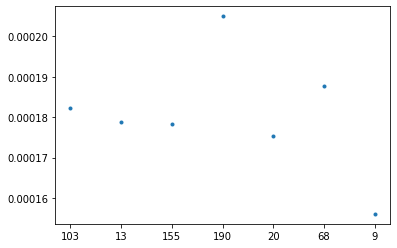

In [16]:
kappa_Si_avg = []
for i, v in enumerate(list(Dict_Si_1.keys())):
    popt, pcov = curve_fit(expo, power_Si[i], avg_dRoverR[i], p0 = [1, 0.0000005, 1], maxfev = 8000)
    #a, b, c = popt
    plt.plot(power_Si[i], avg_dRoverR[i], '.')
    y_pred = [expo(j, *popt) for j in power_Si[i]]
    plt.plot(power_Si[i], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_fit_figure_avg/{}mm.png".format(v), format="PNG")
    plt.close()
    f = expo(Si_melting_W[v], *popt)
    gold_m = 1410
    dT = gold_m - 21
    kappa = f / dT
    kappa_Si_avg.append(kappa)
    
Dict_kappa_Si_avg = dict(zip(list(Dict_Si_1.keys()),kappa_Si_avg))

plt.plot(list(Dict_Si_1.keys()), kappa_Si_avg, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_Si_avg.png", format="PNG")

In [17]:
kappa_Si = sum(kappa_Si_avg)/len(kappa_Si_avg)
kappa_Si

0.00018049092701924972

In [18]:
Dict_kappa_Si_avg

{'103': 0.0001821830814584574,
 '13': 0.00017887335195748173,
 '155': 0.00017821929376736582,
 '190': 0.0002049231934673776,
 '20': 0.00017543130389956118,
 '68': 0.00018769970279448569,
 '9': 0.00015610656179001862}

In [19]:
Si_list = [int(i) for i in Si_list]
ln_velocity = [np.log(i) for i in Si_list]

# Fit plane

### with avg kappa, all 11 velocity

In [20]:
dRoverR_1_all = []
for i, v in enumerate(list(fivemm_files.keys())):
    con = []
    for file in fivemm_files[v][10:]:
        val = get_peak_dRoverR(file, back_intensity_list[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1_all.append(con)

/Users/chiaentsai/.virtualenvs/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [21]:
for i in range(0,len(dRoverR_1_all),1):
    dRoverR_1_all[i] = dRoverR_1_all[i][:-1]

In [22]:
peak_temp_avgk = []
for i, v in enumerate(list(fivemm_files.keys())):
    tem = []
    for r in dRoverR_1_all[i]:
        t = get_peak_Temp(r, kappa_Si)
        tem.append(t)
    peak_temp_avgk.append(tem)
    
Dict_peak_temp_avgk = dict(zip(list(fivemm_files.keys()),peak_temp_avgk))

<IPython.core.display.Javascript object>


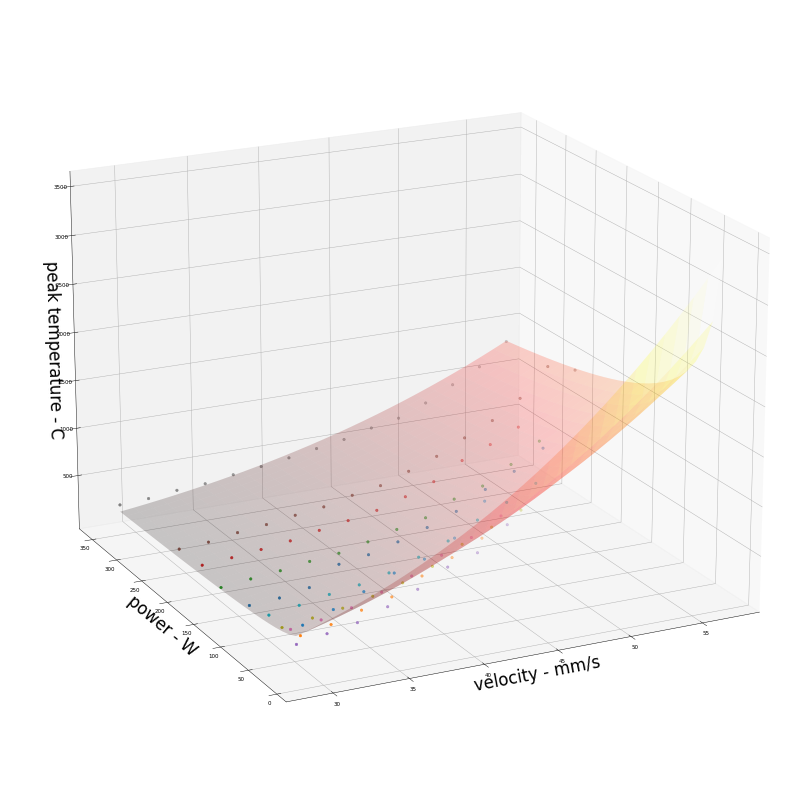

6117.9127691957865


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_57016/430647698.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [131]:
def function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(fivemm_files.keys())):
    P = [int(p) for p in power_list[i][1:-1]]
    V = [int(v)] * len(peak_temp_avgk[i])
    T = Dict_peak_temp_avgk[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
    
parameters, covariance = curve_fit(function, [x_data, y_data], z_data)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()

axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

for i, v in enumerate(list(fivemm_files.keys())):
    v_data = [int(v)] * len(peak_temp_avgk[i])
    p_data = [int(p) for p in power_list[i][1:-1]]
    t_data = Dict_peak_temp_avgk[v]
    axes.scatter(p_data, v_data, t_data)

axes.set_title('Scatter Plot')
axes.set_xlabel('velocity - mm/s', fontsize=30)
axes.set_ylabel('power - W',fontsize=30)
axes.set_zlabel('peak temperature - C', fontsize=30)

plt.show()
print(mse)

In [109]:
def get_power(dwell, Tpeak):
    v = 88200/dwell
    return (Tpeak / (v**parameters[2]) / parameters[0] )**(1/parameters[1])

### with avg kappa, all 11 ln velocity

<IPython.core.display.Javascript object>


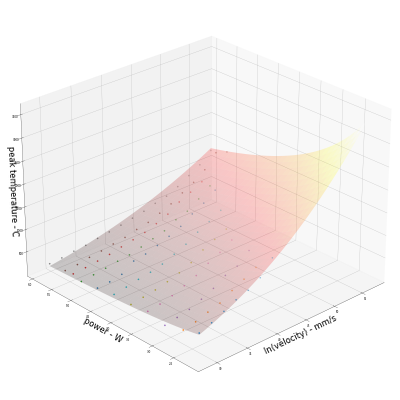

7235.478394809569


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_57016/1401995312.py:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


In [115]:

def function(data, a, b, c):
    x = data[0]
    y = data[1]
    return a * (x**b) * (y**c)

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(fivemm_files.keys())):
    P = [int(p) for p in power_list[i][1:-1]]
    V = [np.log(int(v))] * len(peak_temp_avgk[i])  # ln(veolcity)
    T = Dict_peak_temp_avgk[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # ln(velocity)
        z_data.append(item[2]) # temperature
    
parameters_2, covariance = curve_fit(function, [x_data, y_data], z_data)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters_2)

z_predicted = function([x_data, y_data], *parameters_2)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()

axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

for i, v in enumerate(list(fivemm_files.keys())):
    v_data = [np.log(int(v))] * len(peak_temp_avgk[i]) #ln(velocity)
    p_data = [int(p) for p in power_list[i][1:-1]]
    t_data = Dict_peak_temp_avgk[v]
    axes.scatter(p_data, v_data, t_data)

axes.set_title('Scatter Plot')
axes.set_xlabel('ln(velocity) - mm/s', fontsize=30)
axes.set_ylabel('power - W',fontsize=30)
axes.set_zlabel('peak temperature - C', fontsize=30)


plt.show()
print(mse)

In [116]:
def get_power_2(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    return (Tpeak / (lnv**parameters_2[2]) / parameters_2[0] )**(1/parameters_2[1])